In [1]:
import json
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter,ScalarFormatter
import datetime as datetime
import numpy as np

In [2]:
#read json
portfolio = pd.read_json(r'C:\Desktop\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Desktop\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Desktop\transcript.json', orient='records', lines=True)

In [3]:
df=pd.DataFrame(transcript['value'].values.tolist(),index=transcript.index)

In [4]:
transcript=transcript.merge(df,left_index=True, right_index=True)

In [5]:
#one hot encode channels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

channel = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [6]:
portfolio=portfolio.merge(channel,left_index=True, right_index=True)

In [7]:
transcript=transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [8]:
customer_tenure=transcript.merge(profile, left_on='person', right_on='id', how='left')

In [9]:
d = datetime.datetime.now() 
customer_tenure['today']=d.strftime('%Y-%m-%d')

In [10]:
customer_tenure['became_member_on'] = pd.to_datetime(customer_tenure['became_member_on'], format='%Y%m%d')

In [11]:
customer_tenure['customer_tenure_in_days'] = (pd.to_datetime(customer_tenure.today) - pd.to_datetime(customer_tenure.became_member_on)).dt.days

In [12]:
customer_tenure['customer_tenure_in_years']=customer_tenure['customer_tenure_in_days']/365

In [13]:
customer_tenure['year'] = customer_tenure.became_member_on.dt.year

In [14]:
cohort_ct=customer_tenure.groupby('year')['person'].nunique().reset_index()

In [17]:
cohort=customer_tenure.groupby(['year'])['amount'].sum().reset_index()
cohort
cohort = cohort.merge(cohort_ct, on='year')
cohort['Avg. Spend by Member Signup Year']=cohort['amount']/cohort['person']
cohort.columns=['Member Signup Year','Total Spending (in dollars)','Cohort Size','Avg. Spend by Member Signup Year']
cohort

,Member Signup Year,Total Spending (in dollars),Cohort Size,Avg. Spend by Member Signup Year
0,2013,23630.30,286,82.623427
1,2014,55746.32,691,80.674848
2,2015,251763.08,1830,137.575454
3,2016,531858.96,3526,150.839183
4,2017,674277.78,6469,104.232150
5,2018,238175.53,4198,56.735476


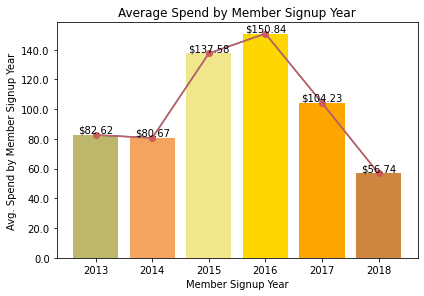

In [21]:
#Slide 8 - Avg spending by Starbucks Member Cohort Signup Year - Bar Graph 
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
sns.lineplot(ax = ax, data = cohort, x = 'Member Signup Year', y = 'Avg. Spend by Member Signup Year')
plt.bar(cohort['Member Signup Year'], cohort['Avg. Spend by Member Signup Year'],
       color=['darkkhaki','sandybrown','khaki','gold','orange','peru'])

#https://stackoverflow.com/questions/70235487/matplotlib-adding-value-labels-to-bar-graph
ax.bar_label(ax.containers[0], label_type='edge', fmt='${:,.2f}')
plt.tight_layout()
plt.plot(cohort['Member Signup Year'], cohort['Avg. Spend by Member Signup Year'], '-o', color='indianred')
plt.title('Average Spend by Member Signup Year')
plt.show()